In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

In [2]:
batch_size = 100
learning_rate = 0.01
epochs = 10

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [4]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)


In [6]:
input_size = 3 * 32 * 32
num_classes = 10
model = LogisticRegressionModel(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


In [11]:
def train_model():
    model.train()
    epoch_losses = []  # List to store average loss for each epoch
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            # Flatten the images
            images = images.view(-1, input_size)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

    return epoch_losses  # Return losses for plotting

def plot_loss_curve(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
    plt.title("Loss Function Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


In [12]:
def evaluate_model():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, input_size)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")

    # Add a return statement to return all_labels and all_preds
    return all_labels, all_preds

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def visualize_predictions():
    all_labels, all_preds = evaluate_model()

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_names = test_dataset.classes

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate and visualize accuracy per class
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_accuracy)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Class")
    plt.xticks(rotation=45)
    plt.show()

    # Visualize a larger set of predictions
    num_samples = 50
    samples_seen = 0
    images, labels = [], []

    for batch_images, batch_labels in test_loader:
        if samples_seen >= num_samples:
            break
        batch_images = batch_images[:num_samples - samples_seen]
        batch_labels = batch_labels[:num_samples - samples_seen]
        images.append(batch_images)
        labels.append(batch_labels)
        samples_seen += batch_images.size(0)

    images = torch.cat(images)
    labels = torch.cat(labels)

    # Make predictions
    images_flat = images.view(-1, input_size)
    outputs = model(images_flat)
    _, preds = torch.max(outputs, 1)

    # Display samples with predictions
    fig, axes = plt.subplots(5, 10, figsize=(15, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        axes[i].imshow((images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5))
        axes[i].set_title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



Epoch [1/10], Loss: 1.6734
Epoch [2/10], Loss: 1.6702
Epoch [3/10], Loss: 1.6673
Epoch [4/10], Loss: 1.6642
Epoch [5/10], Loss: 1.6620
Epoch [6/10], Loss: 1.6590
Epoch [7/10], Loss: 1.6570
Epoch [8/10], Loss: 1.6546
Epoch [9/10], Loss: 1.6533
Epoch [10/10], Loss: 1.6514


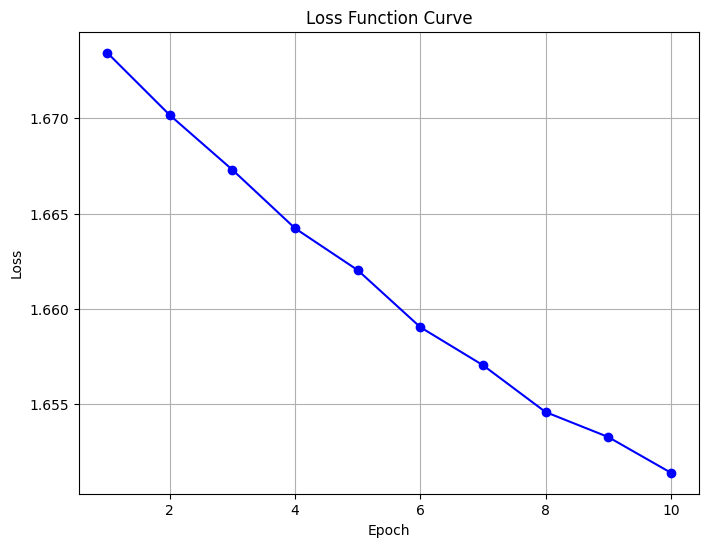

Test Accuracy: 0.4065
Test Accuracy: 0.4065


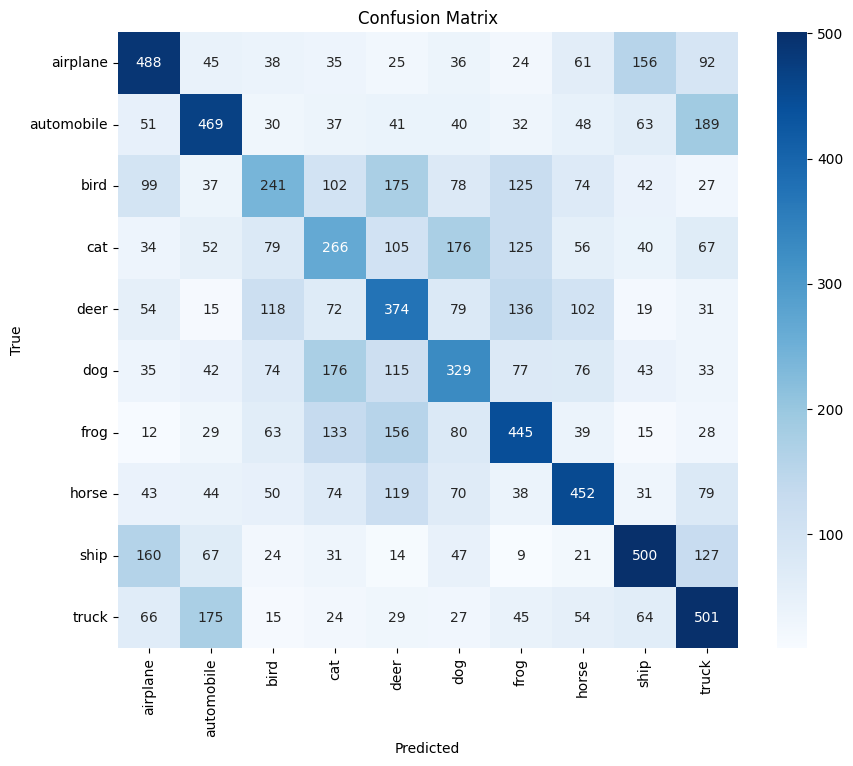

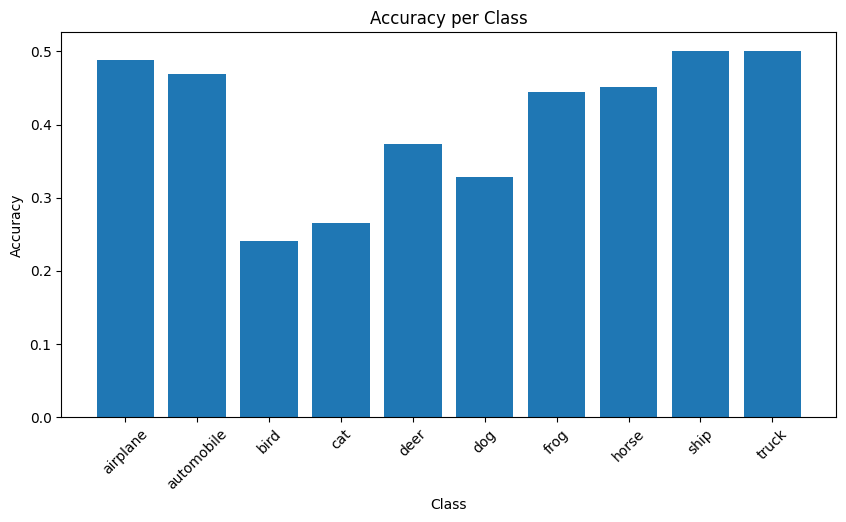

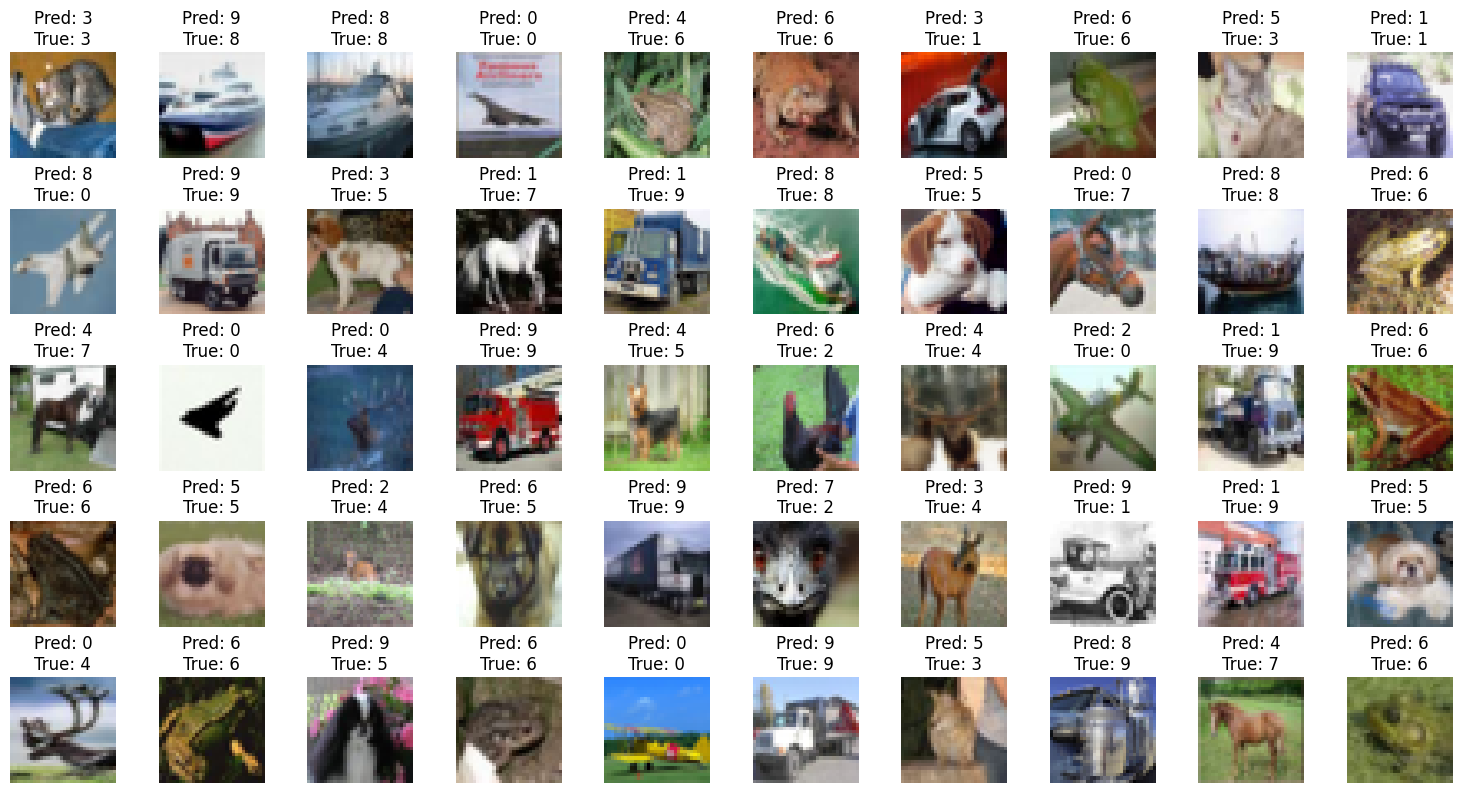

In [14]:
if __name__ == "__main__":
    epoch_losses = train_model()  # Get the list of losses
    plot_loss_curve(epoch_losses)  # Plot the loss curve
    evaluate_model()
    visualize_predictions()
